In [1]:
! pip install -q keras

In [8]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
import pickle
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
# from keras.layers.core import *
# from tensorflow.keras.callbacks import *
# from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

1. Define configurations

In [9]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64
C = Config()

2. Define data processing functions

In [10]:
# Temple resizing function
import numpy as np
import os
import pandas as pd
import random
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

###################################################################################


#Rescale to be 64 frames
def zoom(p,target_l=64,joints_num=25,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim])
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
    return p_new

def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        #distance max
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')
        d_m = d_m[iu]
        M.append(d_m)
    M = np.stack(M)
    return M

def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args:
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%.1f' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%\n%d' % (p, c)
                annot[i, j] = '%.1f' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False, cmap="YlGnBu")
    plt.savefig(filename)

3. Define network

In [11]:

def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W])
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast

def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))

    diff_slow,diff_fast = pose_motion(P,frame_l)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)

    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))
    P = Input(name='P', shape=(frame_l,joint_n,joint_d))

    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)

    x = FM([M,P])

    x = GlobalMaxPool1D()(x)

    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [12]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)
DD_Net.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ M (InputLayer)            │ (None, 32, 231)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ P (InputLayer)            │ (None, 32, 22, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 4, 512)         │      1,740,160 │ M[0][0], P[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ functional[0][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         65,536 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 128)            │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ leaky_re_lu_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         16,384 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 128)            │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ leaky_re_lu_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 14)             │          1,806 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,824,910 (6.96 MB)

 Trainable params: 1,819,278 (6.94 MB)

 Non-trainable params: 5,632 (22.00 KB)


4. Load dataset (download GT_train_1.pkl and  GT_test_1.pkl from github )

In [13]:
!wget https://github.com/fandulu/DD-Net/archive/master.zip
!unzip master.zip
!rm master.zip

--2024-12-10 18:39:33--  https://github.com/fandulu/DD-Net/archive/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master [following]
--2024-12-10 18:39:33--  https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [         <=>        ]  79.09M  14.7MB/s    in 5.4s    

2024-12-10 18:39:38 (14.7 MB/s) - ‘master.zip’ saved [82934337]

Archive:  master.zip
f26a9994b0bafc41096fa269eab89c2757d71499
   creating: DD-Net-master/
  inflating: DD-Net-master/.gitignore  
   creating: DD-Net-master/JHMDB/

5. Running codes

In [14]:
Train = pickle.load(open("/content/DD-Net-master/data/SHREC/train.pkl", "rb"))
Test = pickle.load(open("/content/DD-Net-master/data/SHREC/test.pkl", "rb"))

X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))):
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)

    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)
X_1 = np.stack(X_1)
Y = np.stack(Y)

  0%|          | 0/1960 [00:00<?, ?it/s]<ipython-input-10-0acc17230e16>:23: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 1960/1960 [00:30<00:00, 64.01it/s]


In [15]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))):
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)

    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0)
X_test_1 = np.stack(X_test_1)
Y_test = np.stack(Y_test)

  0%|          | 0/840 [00:00<?, ?it/s]<ipython-input-10-0acc17230e16>:23: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 840/840 [00:20<00:00, 40.90it/s]


In [16]:
# it may takes several times to reach the reported performance
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=400,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)
            )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=500,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)
            )

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.0679 - loss: 3.4735 - val_accuracy: 0.0690 - val_loss: 2.6388 - learning_rate: 1.0000e-04
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.0750 - loss: 3.3312 - val_accuracy: 0.0750 - val_loss: 2.6386 - learning_rate: 1.0000e-04
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.0837 - loss: 3.2563 - val_accuracy: 0.0869 - val_loss: 2.6386 - learning_rate: 1.0000e-04
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.0918 - loss: 3.1509 - val_accuracy: 0.0976 - val_loss: 2.6386 - learning_rate: 1.0000e-04
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.0964 - loss: 3.1208 - val_accuracy: 0.0762 - val_loss: 2.6386 - learning_rate: 1.0000e-04
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1224 - loss: 2.9545 - val_accuracy: 0.0845 - val_loss: 2.6386 - learning_rate: 1.0000e-04
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.1168 - loss:

6.Plotting results

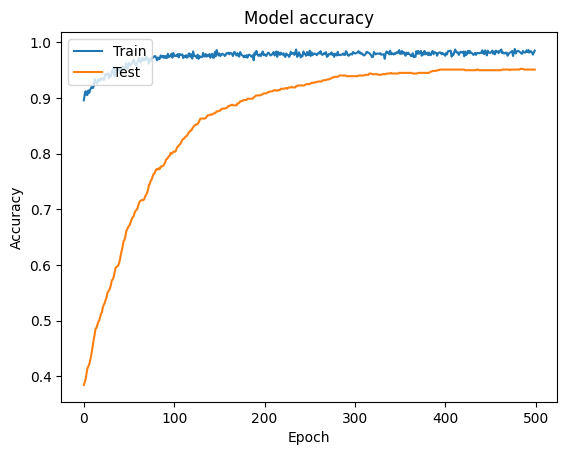

In [17]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


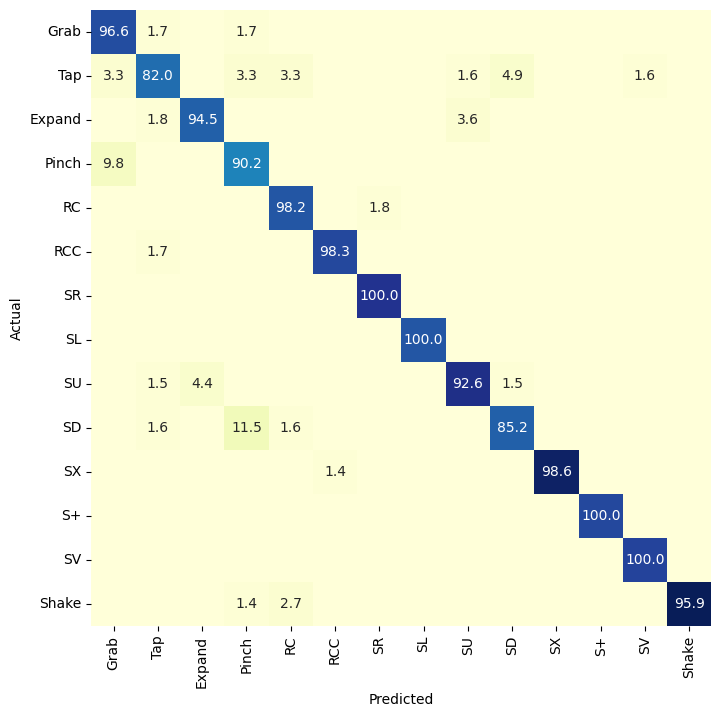

In [18]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])

y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

cm_analysis(y_true,y_pred, 'SHREC_14.png', labels, ymap=None, figsize=(8,8))